## Introduction 
This notebook subsumes the information of <a href="https://medium.com/@lamunozs/dealing-with-skewed-data-a-practical-guide-part-i-394f725092cb"> this informative medium article</a>

The dataset used here can be found on <a href="https://www.kaggle.com/datasets/orvile/health-and-sleep-relation-2024"> Kaggle </a>

## import libraries & load data

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm 
from scipy.stats import shapiro
from scipy.stats import kstest, norm
from statsmodels.stats.diagnostic import lilliefors

from scipy import stats
from scipy.stats import boxcox
import pingouin as pg
from sklearn.preprocessing import PowerTransformer

In [128]:
df = pd.read_csv(r"./data/Sleep_health_and_lifestyle_dataset.csv")

## Short overview of the data

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [130]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [131]:
df.nunique()

Person ID                  374
Gender                       2
Age                         31
Occupation                  11
Sleep Duration              27
Quality of Sleep             6
Physical Activity Level     16
Stress Level                 6
BMI Category                 4
Blood Pressure              25
Heart Rate                  19
Daily Steps                 20
Sleep Disorder               2
dtype: int64

## Why is my data non-normal?

1. Poor experimental design: 
    * **Sampling bias:** Data exhibits no good representation of the population
    * **Confounding variables:** if Confounding variables not controlled, they can introduce distortion
    * **Small Sample Sizes:** Small sample sizes -> more susceptible to outliers
    * **Measurement Errors:** Inaccurate or inconsistent measurement tools can introduce bias
    * **Non-Random Assignment:** if participants are not randomly assigned to experimental and control groups, the groups might differ in ways that affect the outcome
2. Nature of data
    * **Abundant sources of variability**
    * **many zero values as a characteristic of the data**
    * **...**


## How can I tell that my data is skewed?

1. Graphical methods
2. Rigorous Methods in Normality Assessment

### 1. Graphical methods

We'll check the Heart Rate in the present dataset which deals with Healt & Sleep measurements

In [132]:
df_sample = df.sample(38)

#### Histogram & Violinplots

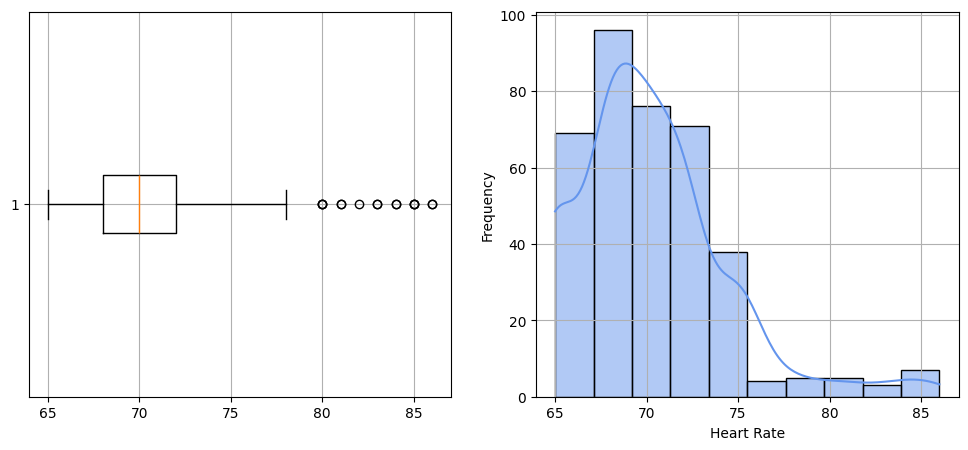

In [133]:
#Integral dataset
fig, sub = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df["Heart Rate"], bins = 10, kde = True, color ="#6495ED",edgecolor="black", ax = sub[1])
sub[1].grid()
sub[1].set_ylabel("Frequency")

sub[0].boxplot(df["Heart Rate"], vert=False)
sub[0].grid()

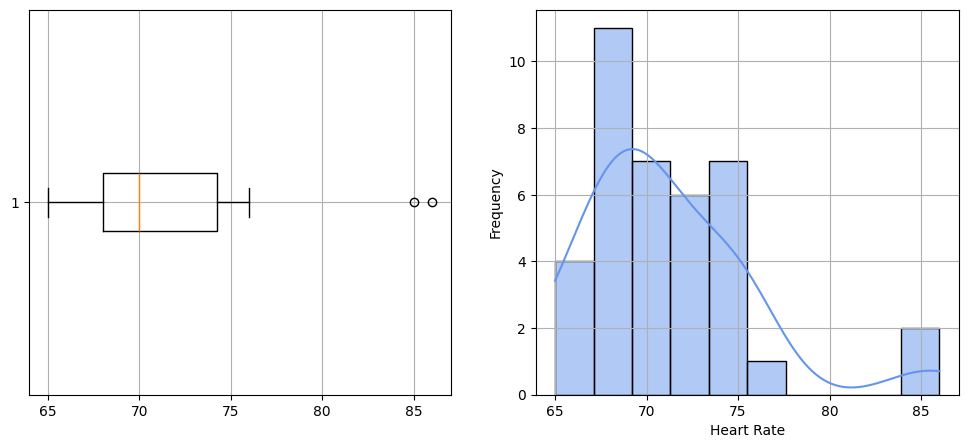

In [134]:
#sample of data
fig, sub = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df_sample["Heart Rate"], bins = 10, kde = True, color ="#6495ED",edgecolor="black", ax = sub[1])
sub[1].grid()
sub[1].set_ylabel("Frequency")

sub[0].boxplot(df_sample["Heart Rate"], vert=False)
sub[0].grid()

* Median left shifted
* Outlier on the right side
* positive skew 

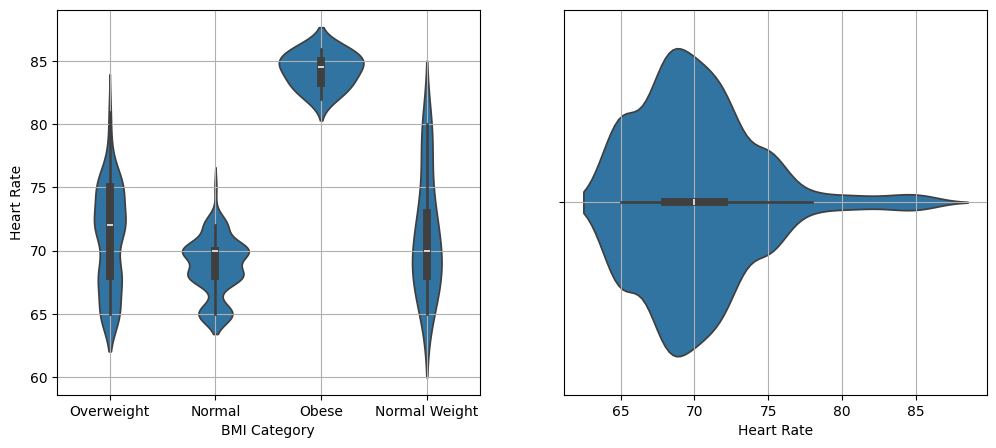

In [135]:
fig, sub = plt.subplots(1,2,figsize=(12,5))

sns.violinplot(x = "BMI Category", y = "Heart Rate", data = df, inner = "box", ax = sub[0])
sns.violinplot(x = "Heart Rate", data = df, ax = sub[1])

for s in sub.flatten():
    s.grid()

#### Mean / Mode / Median

* Normal-Distribution: Mean = Mode = Median
* Positive skew (right-skewed): Mode < Median < Mean
* Negative skew (left-skewed): Mean < Median < Mode 

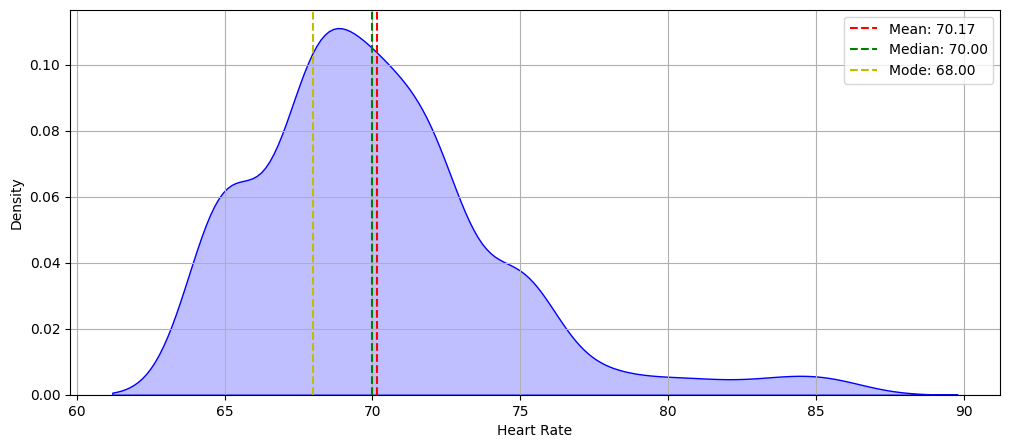

In [136]:
fig, sub = plt.subplots(1,1, figsize=(12,5))

sns.kdeplot(df["Heart Rate"], fill = True, color = "b")
sub.axvline(df["Heart Rate"].mean(), color = "r", ls = "--", label = f"Mean: {df['Heart Rate'].mean():.2f}")
sub.axvline(df["Heart Rate"].median(), color = "g", ls = "--", label = f"Median: {df['Heart Rate'].median():.2f}")
sub.axvline(df["Heart Rate"].mode().values[0], color = "y", ls = "--", label = f"Mode: {df["Heart Rate"].mode().values[0]:.2f}")

sub.legend()
sub.grid()

### 2. Rigorous Methods in Normality Assessment

There are two popular possibilities to test if a feature follows a normal distribution: <br>
a) Hypothesis testing <br>
b) Evaluation of graphical representations

---

a) Hypothesis Testing

There are two main tests to test for normality:
* **Shapiro-Wilk:** Used when sample size < 30 (small)
* **Kolmogorov-Smirnov (Lilliefors):** Used with sample sizes greater than 30 

Further tests: Anderson-Darling & Ryan-Joiner as modifications of the previously mentioned tests.

**Lilliefors** 

$H_{0}:$ The distribution is equal to a normal distribution <br>
$H_{1}:$ The distribution does not come form a normal distribution

In [137]:
statistic, p_val = lilliefors(df["Heart Rate"])
print(f"Lilliefors statistic: {statistic: .2f}")
print(f"P-Value: {p_val: .2f}")

Lilliefors statistic:  0.16
P-Value:  0.00


**Shapiro-Wilk**

$H_{0}:$ The distribution is equal to a normal distribution <br>
$H_{1}:$ The distribution does not come form a normal distribution

In [138]:
statistics, p_val = shapiro(df_sample["Heart Rate"])
print(f"Shapiro-Wilk statistic: {statistics: .2f}")
print(f"P-Value: {p_val: .2f}")

Shapiro-Wilk statistic:  0.85
P-Value:  0.00


b) Evaluation of graphical representation

**QQ-Plot**

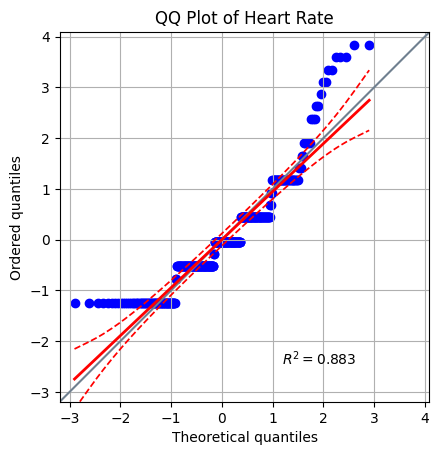

In [139]:
sub = pg.qqplot(df["Heart Rate"], dist = "norm", confidence=0.95)
sub.set_title("QQ Plot of Heart Rate")
sub.grid()

# Summary skewness challenge identification

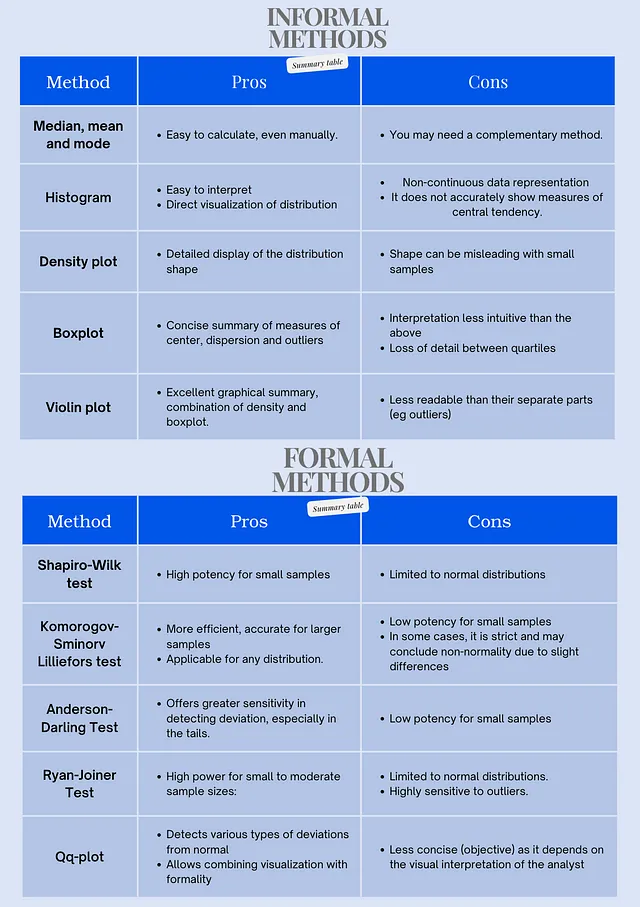

# Data Transformation

**Short Definition:**<br>

Any change in the format of data. The process is structured into an organized sequence of stages: data discovery, cleansing, manipulation or transformation, validation, testing. 

**Normalization vs. Standardization**

* Normalization: Adjusting the full range of data to fit it within a defined interval (e.g. [0,1])
* Standardization: Transformation of the data that it has a mean of 0 and a stdv of 1

**Trade-off when transforming data: Interpretation**

* easy temptation to transform any variable not meeting the expectation
* but: transformation can complicate the interpretation of the data
* but: might allow to use specific statistical tools by stabilizing the variance
* non-parametric techniques can be valuable alternatives

**How to transform data**

Positive Skew

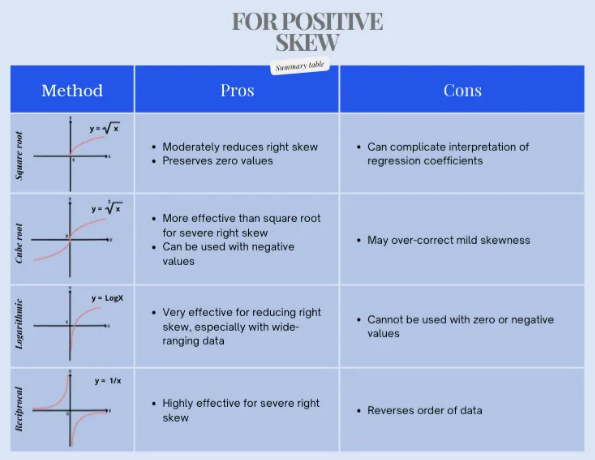

Negative Skew

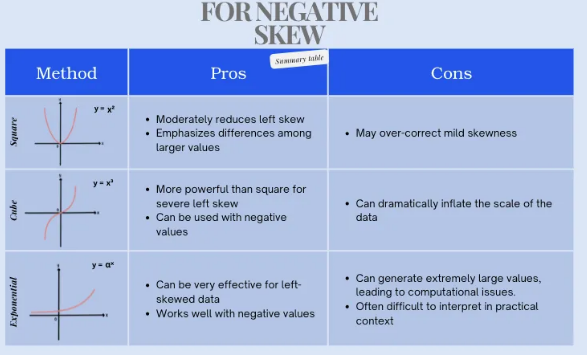

In [142]:
df.columns

Index(['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration',
       'Quality of Sleep', 'Physical Activity Level', 'Stress Level',
       'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps',
       'Sleep Disorder'],
      dtype='object')

In [148]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [188]:
df["Blood_pressure_systolic"] = df["Blood Pressure"].str.split("/").str[0].astype("int")
df["Blood_pressure_diastolic"] = df["Blood Pressure"].str.split("/").str[1].astype("int")
df_occupation = df[df["Occupation"] == 'Doctor'].copy()

#### Simple Transformations

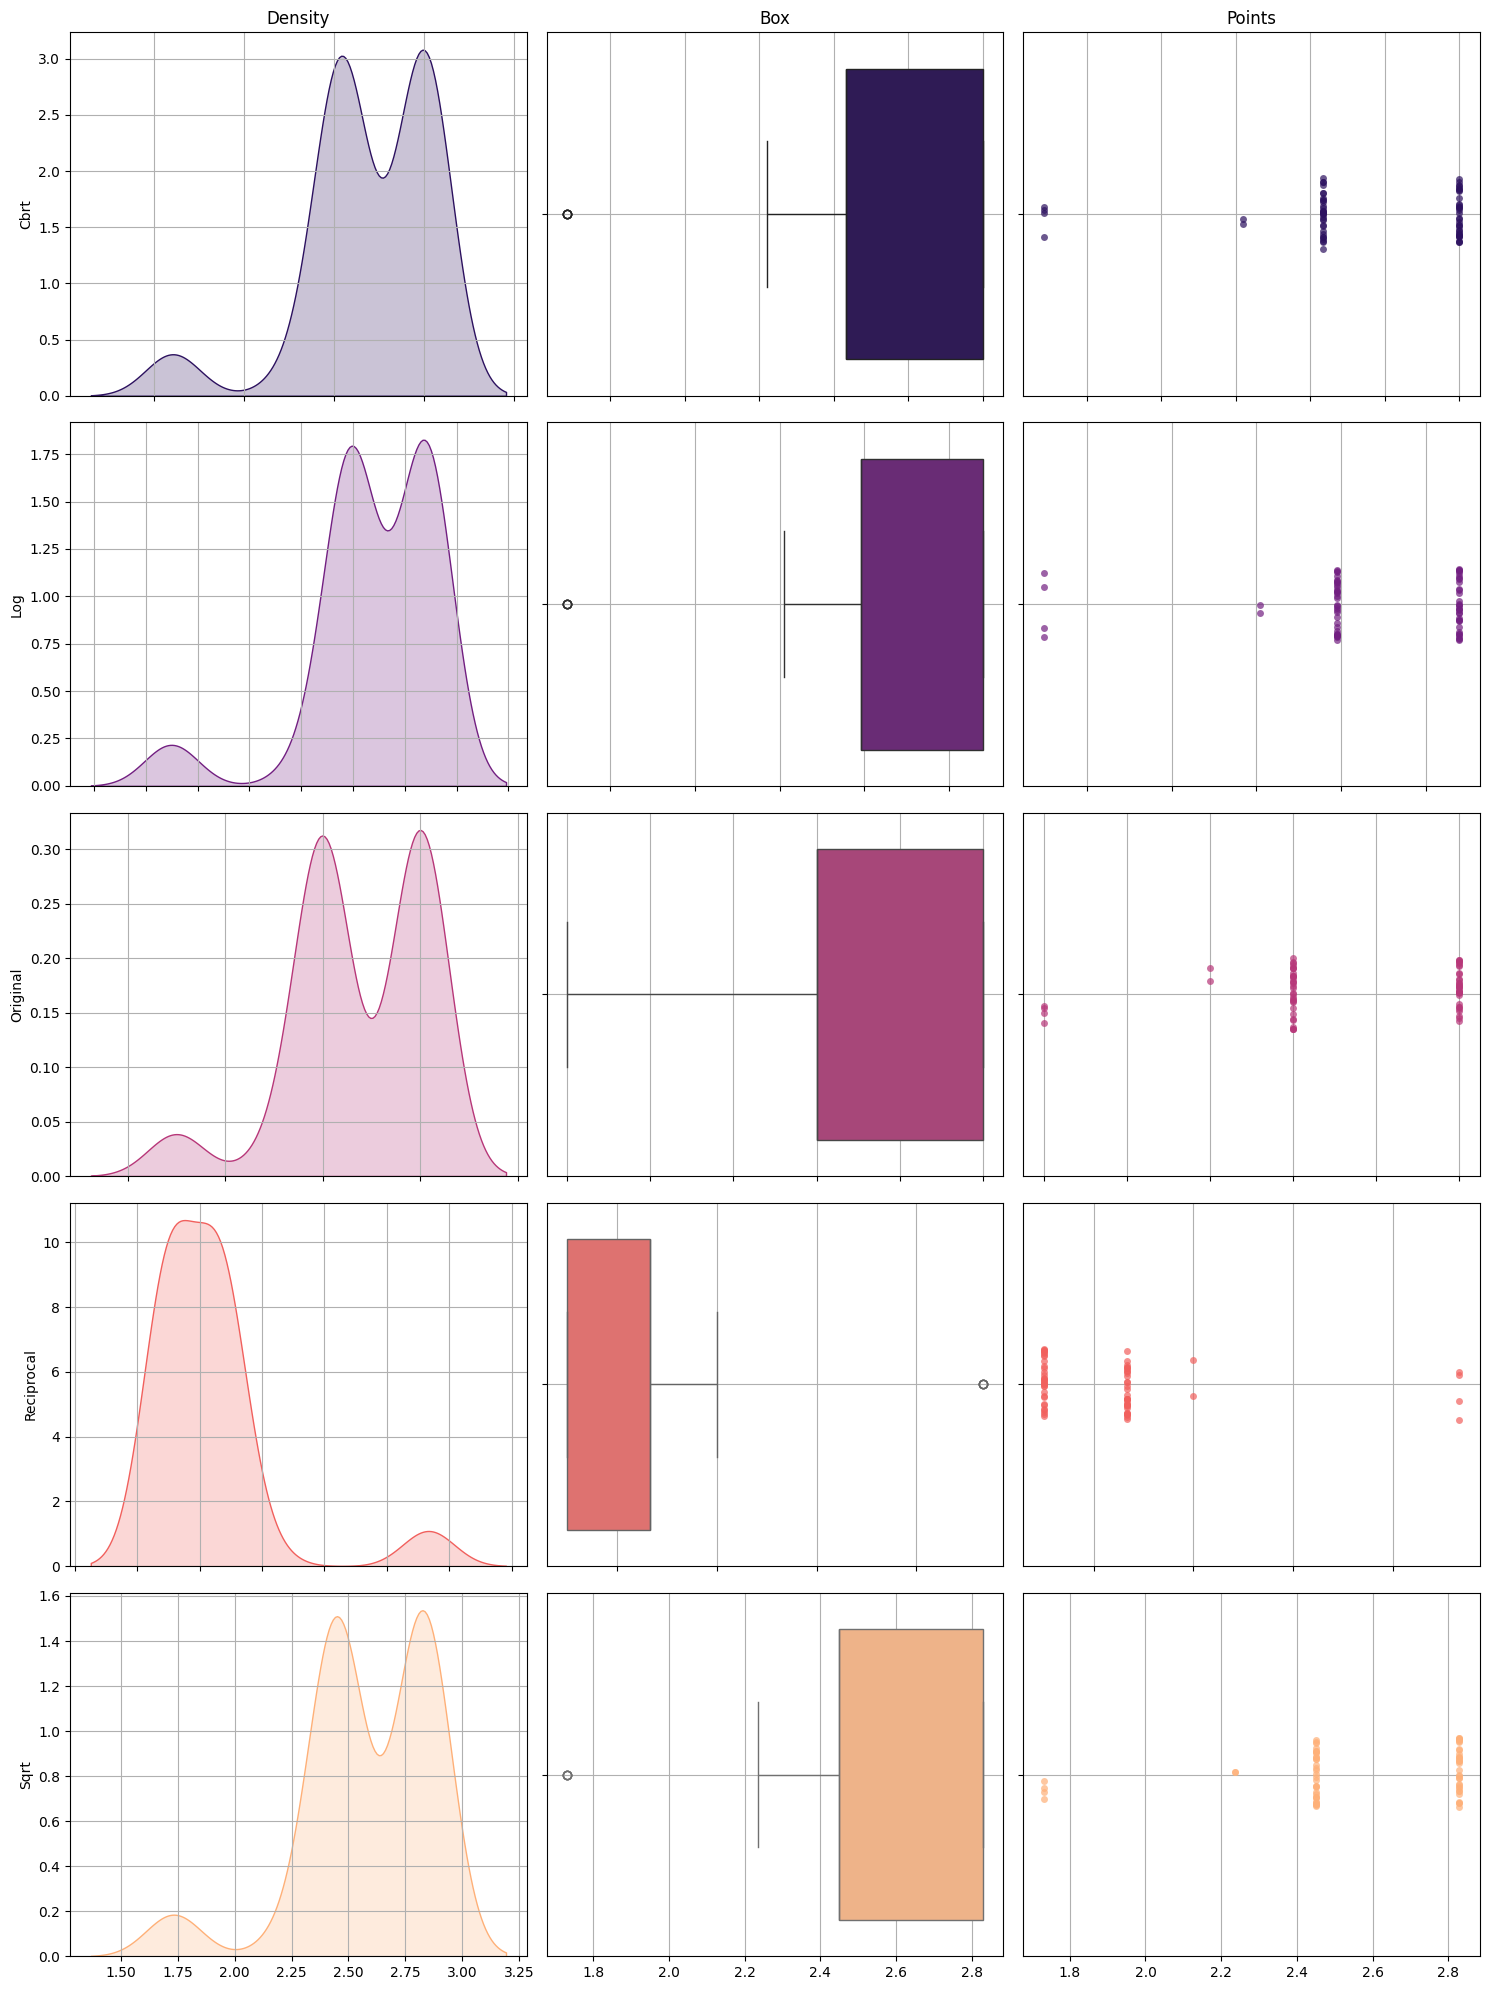

In [194]:
# Dictionary of functions
def safe_transform(x, func):
    if func == 'sqrt':
        return np.sqrt(x) if x >= 0 else np.nan
    elif func == 'reciprocal':
        return 1 / x if x != 0 else np.nan
    elif func == 'log':
        return np.log(x) if x > 0 else np.nan
    else:  # 'cbrt' transformation as default
        return np.cbrt(x)

transformations = {
    'Original': lambda x: x,
    'Sqrt': lambda x: safe_transform(x, 'sqrt'),
    'Cbrt': lambda x: safe_transform(x, 'cbrt'),
    'Reciprocal': lambda x: safe_transform(x, 'reciprocal'),
    'Log': lambda x: safe_transform(x, 'log')
}

# Apply transformations
col = "Stress Level"
df_ = pd.DataFrame({name: [func(x) for x in df_occupation[col]] for name, func in transformations.items()})

df_long = pd.melt(df_, var_name='Transformation', value_name='Value').dropna(subset=['Value'])

# For plots
fig, axes = plt.subplots(5, 3, figsize=(15, 20), sharex=False, sharey=False)
plot_types = ['Density', 'Box', 'Points']
colors = sns.color_palette("magma", len(transformations))

for i, (transformation, data) in enumerate(df_long.groupby('Transformation')):
    for j, plot_type in enumerate(plot_types):
        ax = axes[i, j]
        if plot_type == 'Density':
            sns.kdeplot(data=data, x='Value', fill=True, ax=ax, color=colors[i])
        elif plot_type == 'Box':
            sns.boxplot(data=data, x='Value', ax=ax, color=colors[i])
        elif plot_type == 'Points':
            sns.stripplot(data=data, x='Value', ax=ax, jitter=True, alpha=0.7, color=colors[i])

        if j == 0:
            ax.set_ylabel(transformation)
        if i == 0:
            ax.set_title(plot_type)
        ax.set_xlabel('')

# Adjust aesthetics and display
for ax in axes.flatten():
    ax.label_outer()
    ax.grid()
fig.tight_layout()
plt.show()

#### Box Cox Transformation

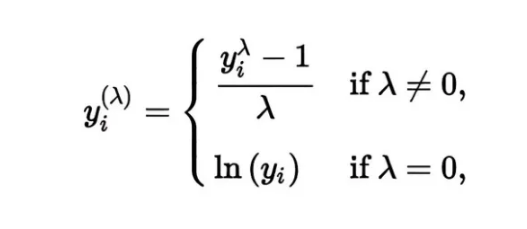

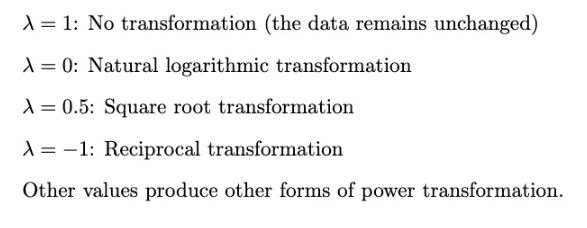

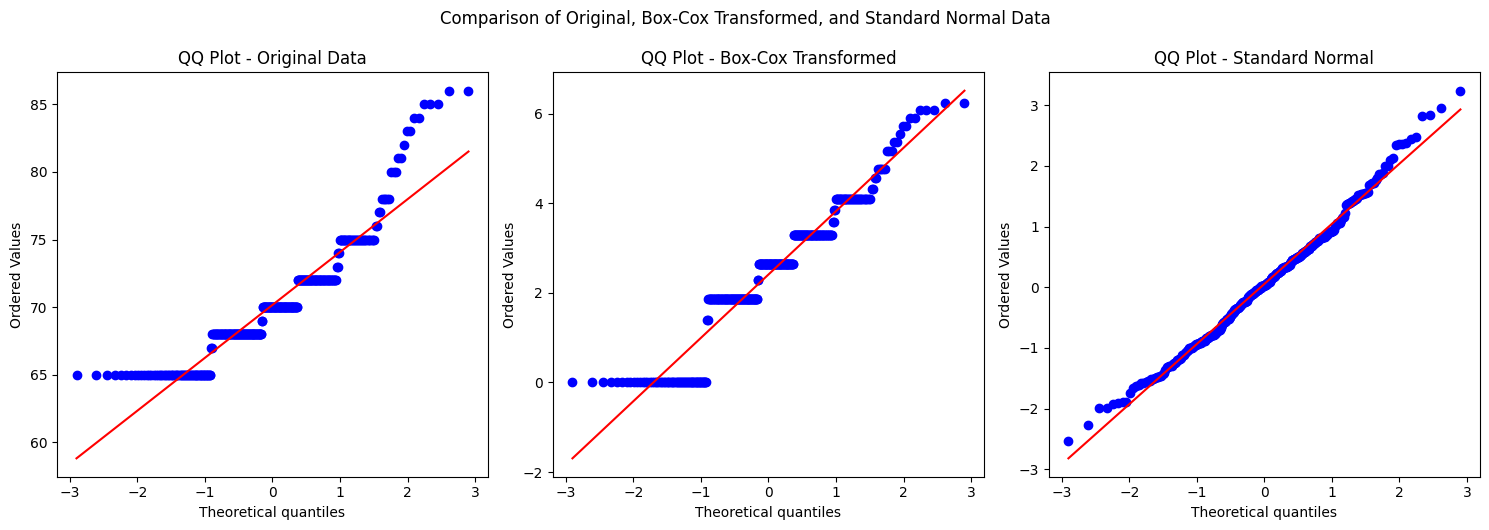

In [201]:
# To generate a standard normal distribution
normal_std = np.random.normal(0, 1, len(df["Heart Rate"]))

# Box-cox transformation
relative_expression1_positive = df["Heart Rate"] - np.min(df["Heart Rate"]) + 1
boxcox_transformed, lambda_value = boxcox(relative_expression1_positive, lmbda=None)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# QQ plot for original data, box cox transformed and standard normal
stats.probplot(df["Heart Rate"], dist="norm", plot=axes[0])
axes[0].set_title('QQ Plot - Original Data')
stats.probplot(boxcox_transformed, dist="norm", plot=axes[1])
axes[1].set_title('QQ Plot - Box-Cox Transformed')
stats.probplot(normal_std, dist="norm", plot=axes[2])
axes[2].set_title('QQ Plot - Standard Normal')

plt.tight_layout()
plt.suptitle('Comparison of Original, Box-Cox Transformed, and Standard Normal Data', y=1.05)
plt.show()

In [ ]:
# Shapiro-Wilk test on Box-Cox transformed data
stat, p_value = shapiro(boxcox_transformed)

# Interpretation
if p_value > 0.05:
    print("The Box-Cox transformed data appears to be normally distributed.")
else:
    print("The Box-Cox transformed data does not appear to be normally distributed.")

The Box-Cox transformed data does not appear to be normally distributed.


#### Yeo-Johnson Transformation

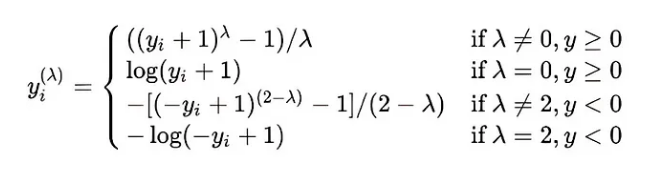

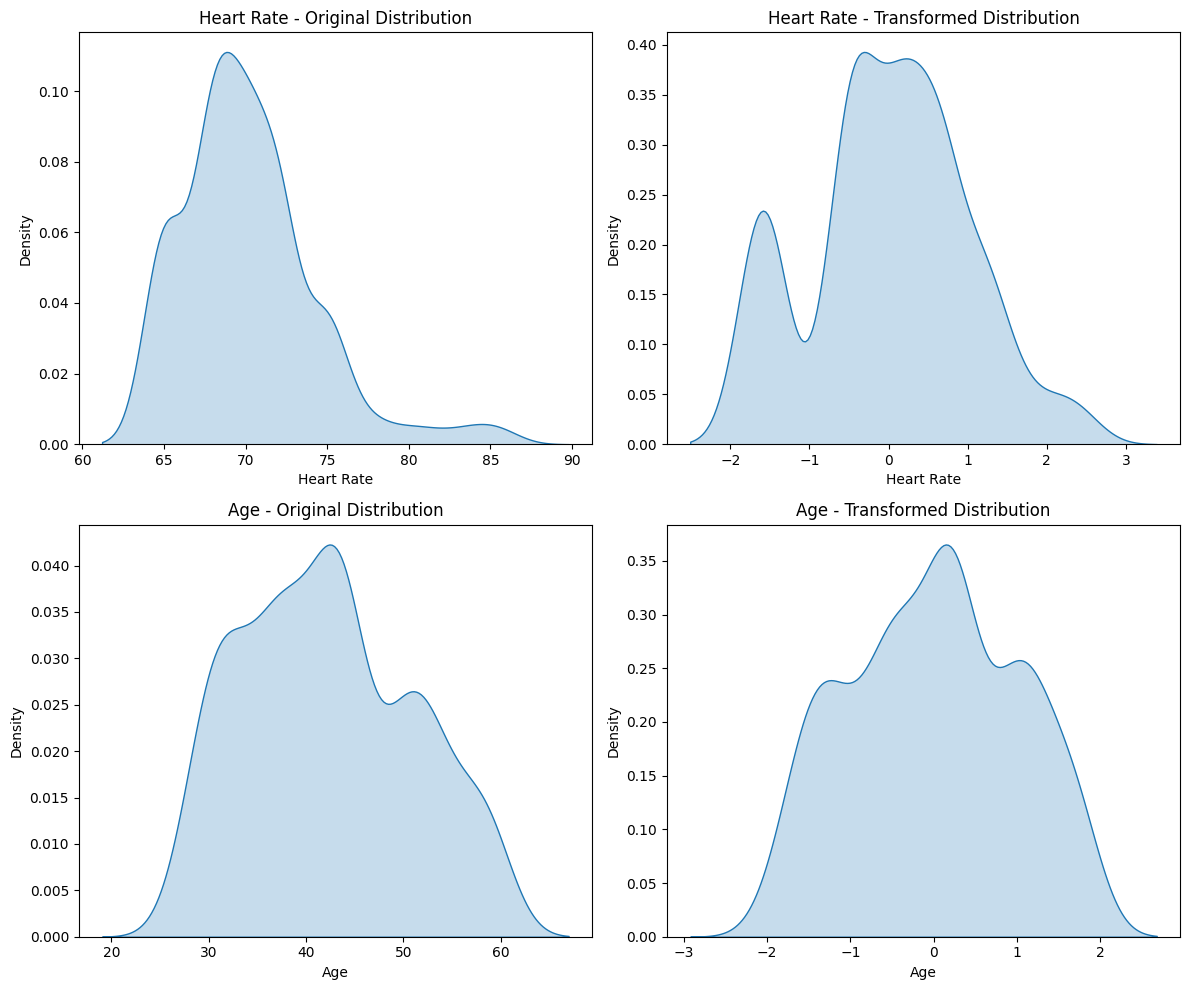

In [207]:
# To apply Yeo-Johnson Transformation
df = pd.DataFrame({'Heart Rate': df["Heart Rate"], 'Age': df["Age"]})
df_transformed = pd.DataFrame(PowerTransformer(method='yeo-johnson').fit_transform(df), columns=df.columns)

# Plot original and transformed distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
titles = ['Original Distribution', 'Transformed Distribution']

for i, (data, label) in enumerate(zip([df, df_transformed], titles)):
    sns.kdeplot(data['Heart Rate'], ax=axes[0, i], fill=True).set_title(f"Heart Rate - {label}")
    sns.kdeplot(data['Age'], ax=axes[1, i], fill=True).set_title(f"Age - {label}")

plt.tight_layout()
plt.show()

#### Closer to Normal Distribution through Outlier Management

* Atypical values can usually be rectified using one of the following methods:
    * Imputation: Impute values with typical values
    * Capping: Values outside the iqr limit are capped

Outliers:
     Heart Rate  Age
3            85   28
4            85   28
5            85   28
6            82   29
16           80   29
18           80   29
80           81   34
81           81   34
93           84   35
145          84   38
147          80   39
264          83   48
266          83   48
276          86   49
277          86   49


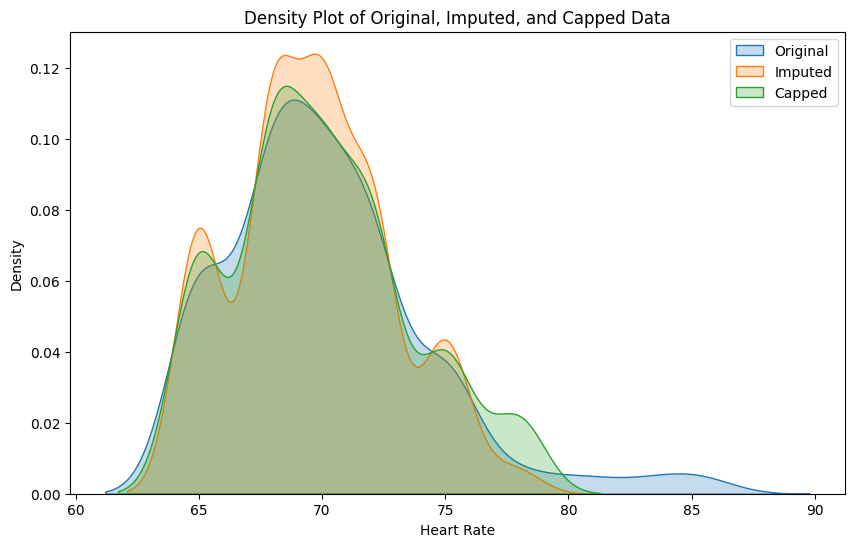

In [210]:
# Detect outliers using the Interquartile Range (IQR) method
def detect_outliers(df, column):
    Q1, Q3 = df[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outliers = detect_outliers(df, 'Heart Rate')
print(f'Outliers:\n{outliers}')

# Impute outliers with the median
median = df['Heart Rate'].median()
df_imputed = df.copy()
df_imputed.loc[df_imputed['Heart Rate'].isin(outliers['Heart Rate']), 'Heart Rate'] = median

# Apply capping to the 5th and 95th percentiles
lower_cap, upper_cap = df['Heart Rate'].quantile([0.05, 0.95])
df_capped = df.copy()
df_capped['Heart Rate'] = df_capped['Heart Rate'].clip(lower_cap, upper_cap)

#This is just for one plot with all distributions. 
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Heart Rate'], label='Original', fill=True)
sns.kdeplot(df_imputed['Heart Rate'], label='Imputed', fill=True)
sns.kdeplot(df_capped['Heart Rate'], label='Capped', fill=True)
plt.xlabel('Heart Rate')
plt.title('Density Plot of Original, Imputed, and Capped Data')
plt.legend()
plt.show()

#### Log-Cosh Tranformation

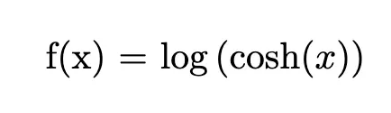

The Log-Cosh transformation is a smooth approximation of the absolute value function, defined as the logarithm of the hyperbolic cosine of the difference between predicted and actual values.